# Data preparation for Blackblaze hardrives dataset 

After agregating the data from 2015, 2016 and 2017 we now prepare it in this notebook for later survival analysis.

This notebook was heavily inspired by a tutorial from Jonathan Sedar : https://blog.applied.ai/survival-analysis-part2/

In [45]:
## Interactive magics - comment out if running from another script
%matplotlib inline
#%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [46]:
from collections import OrderedDict
import re
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import StratifiedShuffleSplit
import triangle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 10, 6

np.random.seed(0)


In [47]:
cnx = sqlite3.connect('drive_stats.db')
csr = cnx.cursor()
df = pd.read_sql('select * from drive_survival', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])
print(df.shape)
df.head() 

(122181, 8)


,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed
diskid,,,,,,,,
,00MD00,4000787030016,2017-04-12,2017-04-18,7,14333,14476,0
0F112CC45,00MD00,4000787030016,2017-04-12,2017-04-18,7,14334,14476,0
13H2B97AS,TOSHIBA DT01ACA300,3000592982016,2015-04-21,2017-07-25,911,10153,29961,0
13H32WEAS,TOSHIBA DT01ACA300,3000592982016,2015-01-01,2017-08-03,1030,14765,37431,0
13H6A21GS,TOSHIBA DT01ACA300,3000592982016,2015-01-01,2017-08-18,1045,14133,37155,0


In [48]:
print(df.shape)
df.head()
df.dtypes

(122181, 8)


model                    object
capacitybytes             int64
mindate          datetime64[ns]
maxdate          datetime64[ns]
nrecords                  int64
minhours                 object
maxhours                 object
failed                    int64
dtype: object

In [49]:
# Removing disk that failed more than once
df = df.loc[df['failed'] <=1]
df.shape

(121786, 8)

In [50]:
df.groupby('capacitybytes').size()

capacitybytes
-9116022715867848704        1
-1                       2715
 80026361856               79
 137438952960               4
 160041885696             213
 250000000000               1
 250059350016             111
 320072933376             100
 500107862016            1839
 1000204886016            640
 1500301910016           2032
 2000398934016           4933
 3000592982016           8367
 4000787030016          65182
 5000981078016             46
 6001175126016           2447
 8001563222016          24611
 10000831348736          1223
 12000138625024          7242
dtype: int64

In [51]:
# Remove drives that have -1 capacity and drives that dont have enough examples
capacities = [500107862016, 1500301910016,4000787030016, 8001563222016, 3000592982016,
              12000138625024, 10000831348736, 6001175126016, 2000398934016]
df = df[df['capacitybytes'].isin(capacities)]
print(df.shape)
df.groupby('capacitybytes').size()

(117876, 8)


capacitybytes
500107862016       1839
1500301910016      2032
2000398934016      4933
3000592982016      8367
4000787030016     65182
6001175126016      2447
8001563222016     24611
10000831348736     1223
12000138625024     7242
dtype: int64

In [52]:
df.groupby(['model']).size()

model
 00MD00                        2
HGST HDS5C4040ALE630         118
HGST HDS724040ALE640          42
HGST HMS5C4040ALE640        8659
HGST HMS5C4040BLE640       16298
HGST HUH728080ALE600          72
HGST HUS726040ALE610          32
Hitachi HDS5C3030ALA630     4597
Hitachi HDS5C3030BLE630        1
Hitachi HDS5C4040ALE630     2659
Hitachi HDS722020ALA330     4663
Hitachi HDS723020BLA642        9
Hitachi HDS723030ALA640     1010
Hitachi HDS723030BLE640       10
Hitachi HDS724040ALE640        3
SAMSUNG HD154UI                2
ST10000NM0086               1223
ST12000NM0007               7242
ST1500DL001                    2
ST1500DL003                   24
ST1500DM003                    3
ST2000DL001                    1
ST2000DL003                    2
ST2000VN000                   10
ST3000DM001                 1168
ST31500341AS                 307
ST31500541AS                1693
ST32000542AS                  83
ST320005XXXX                   2
ST33000651AS                 279
ST35

In [53]:
# In the database manufacturer info in with model we need to split them in two features
df['manufacturer'] = df['model'].apply(lambda x: x.split()[0])
df['model'] = df['model'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else x)
df['manufacturer'] = df['manufacturer'].apply(lambda x: 'SEAGATE' if x[:2] == 'ST' else x)
# HGST is Hitachi
df.loc[df['manufacturer'] == 'Hitachi','manufacturer'] = 'HGST'
df.groupby(['manufacturer','model']).size()

manufacturer  model          
00MD00         00MD00                2
HGST          HDS5C3030ALA630     4597
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2777
              HDS722020ALA330     4663
              HDS723020BLA642        9
              HDS723030ALA640     1010
              HDS723030BLE640       10
              HDS724040ALE640       45
              HMS5C4040ALE640     8659
              HMS5C4040BLE640    16298
              HUH728080ALE600       72
              HUS726040ALE610       32
SAMSUNG       HD154UI                2
SEAGATE       HN                   802
              ST10000NM0086       1223
              ST12000NM0007       7242
              ST1500DL001            2
              ST1500DL003           24
              ST1500DM003            3
              ST2000DL001            1
              ST2000DL003            2
              ST2000VN000           10
              ST3000DM001         1168
              ST31500341AS        

In [54]:
# We remove manufacturer 00MD00, seems weird, only 2 disks anyways
df = df.loc[df['manufacturer'] != '00MD00']
df.groupby(['manufacturer','model']).size()

manufacturer  model          
HGST          HDS5C3030ALA630     4597
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2777
              HDS722020ALA330     4663
              HDS723020BLA642        9
              HDS723030ALA640     1010
              HDS723030BLE640       10
              HDS724040ALE640       45
              HMS5C4040ALE640     8659
              HMS5C4040BLE640    16298
              HUH728080ALE600       72
              HUS726040ALE610       32
SAMSUNG       HD154UI                2
SEAGATE       HN                   802
              ST10000NM0086       1223
              ST12000NM0007       7242
              ST1500DL001            2
              ST1500DL003           24
              ST1500DM003            3
              ST2000DL001            1
              ST2000DL003            2
              ST2000VN000           10
              ST3000DM001         1168
              ST31500341AS         307
              ST31500541AS        

In [55]:
# Make capacity human readable 
df['capacity'] = df['capacitybytes'].apply(lambda x: '{}TB'.format(round(x / 1e12,2)))
df.groupby(['capacity']).size()

capacity
0.5TB      1839
1.5TB      2032
10.0TB     1223
12.0TB     7242
2.0TB      4933
3.0TB      8367
4.0TB     65180
6.0TB      2447
8.0TB     24611
dtype: int64

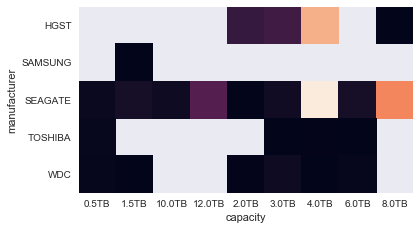

In [56]:
# Remove too small groups by manufacturer 
gp = df.groupby(['manufacturer','capacity']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

In [57]:
# Feature engineering date year month
df['mindateym'] = df['mindate'].apply(lambda x: x.strftime('%Y%m'))
df['maxdateym'] = df['maxdate'].apply(lambda x: x.strftime('%Y%m'))


In [58]:
df.head()

,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,,
13H2B97AS,DT01ACA300,3000592982016,2015-04-21,2017-07-25,911,10153,29961,0,TOSHIBA,3.0TB,201504,201707
13H32WEAS,DT01ACA300,3000592982016,2015-01-01,2017-08-03,1030,14765,37431,0,TOSHIBA,3.0TB,201501,201708
13H6A21GS,DT01ACA300,3000592982016,2015-01-01,2017-08-18,1045,14133,37155,0,TOSHIBA,3.0TB,201501,201708
13H7X2HAS,DT01ACA300,3000592982016,2015-12-17,2017-04-26,583,9775,21667,0,TOSHIBA,3.0TB,201512,201704
13H80PNGS,DT01ACA300,3000592982016,2015-01-01,2015-08-13,225,11765,17138,0,TOSHIBA,3.0TB,201501,201508


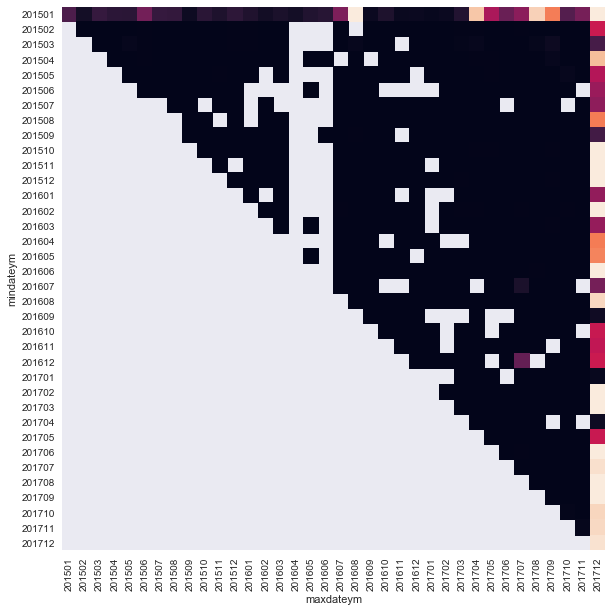

In [59]:
gp = df.groupby(['mindateym','maxdateym']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

In [60]:
# Mitagation of left truncation we use SMART_9_RAW
# Remove the rows that don't have minhours maxours info
print(df.shape[0])
print(df['minhours'].apply(np.isreal).sum())
print(df['maxhours'].apply(np.isreal).sum()) 

df = df.loc[df['maxhours'].apply(np.isreal)].copy()
df.shape


117874
117874
117840


(117840, 12)

In [61]:
df['minhours'] = df['minhours'].astype(np.int64)
df['maxhours'] = df['maxhours'].astype(np.int64)
df.head()

,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,,
13H2B97AS,DT01ACA300,3000592982016,2015-04-21,2017-07-25,911,10153,29961,0,TOSHIBA,3.0TB,201504,201707
13H32WEAS,DT01ACA300,3000592982016,2015-01-01,2017-08-03,1030,14765,37431,0,TOSHIBA,3.0TB,201501,201708
13H6A21GS,DT01ACA300,3000592982016,2015-01-01,2017-08-18,1045,14133,37155,0,TOSHIBA,3.0TB,201501,201708
13H7X2HAS,DT01ACA300,3000592982016,2015-12-17,2017-04-26,583,9775,21667,0,TOSHIBA,3.0TB,201512,201704
13H80PNGS,DT01ACA300,3000592982016,2015-01-01,2015-08-13,225,11765,17138,0,TOSHIBA,3.0TB,201501,201508


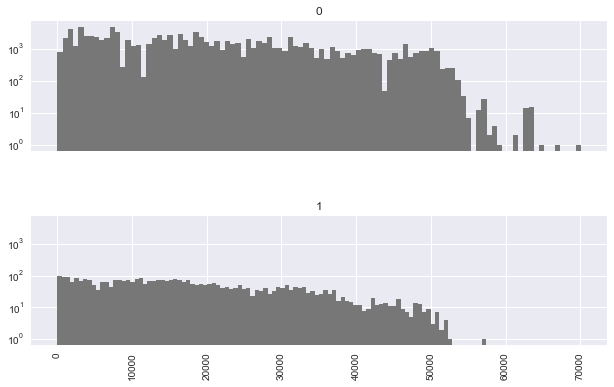

In [62]:
ax=df.hist(column='maxhours', by='failed', bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

In [63]:
# Removing unecessary column
del df['capacitybytes']

In [66]:
print(df.shape)
df.describe()
df.head()

(117840, 11)


,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
13H2B97AS,DT01ACA300,2015-04-21,2017-07-25,911,10153,29961,0,TOSHIBA,3.0TB,201504,201707
13H32WEAS,DT01ACA300,2015-01-01,2017-08-03,1030,14765,37431,0,TOSHIBA,3.0TB,201501,201708
13H6A21GS,DT01ACA300,2015-01-01,2017-08-18,1045,14133,37155,0,TOSHIBA,3.0TB,201501,201708
13H7X2HAS,DT01ACA300,2015-12-17,2017-04-26,583,9775,21667,0,TOSHIBA,3.0TB,201512,201704
13H80PNGS,DT01ACA300,2015-01-01,2015-08-13,225,11765,17138,0,TOSHIBA,3.0TB,201501,201508


In [67]:
# We save the prepared data 
df.to_sql('drive_survival_prepared', con=cnx, if_exists='replace', index_label='diskid')

SyntaxError: invalid syntax (<ipython-input-20-eae7f0a6302f>, line 1)

In [68]:
df.to_csv('../drive_survival_prepared.csv', index=True, index_label='diskid')